In [3]:

import numpy as np
import librosa
import os
from os import walk
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import datetime 

In [4]:
def get_mfcc(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=2)
  mfcc = np.array(librosa.feature.mfcc(y=y, sr=sr))
  return mfcc

def get_melspectrogram(wav_file_path):
  y, sr = librosa.load(wav_file_path, offset=0, duration=2)
  melspectrogram = np.array(librosa.feature.melspectrogram(y=y, sr=sr))
  return melspectrogram

def get_chroma_vector(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
  return chroma

def get_tonnetz(wav_file_path):
  y, sr = librosa.load(wav_file_path)
  tonnetz = np.array(librosa.feature.tonnetz(y=y, sr=sr))
  return tonnetz

In [6]:
example_file = r"Chords_generation\chords_wav\F_A#aug.wav"
y, sr = librosa.load(example_file, offset=0, duration=2)

[Text(0.5, 1.0, 'MFCC pour un La maj')]

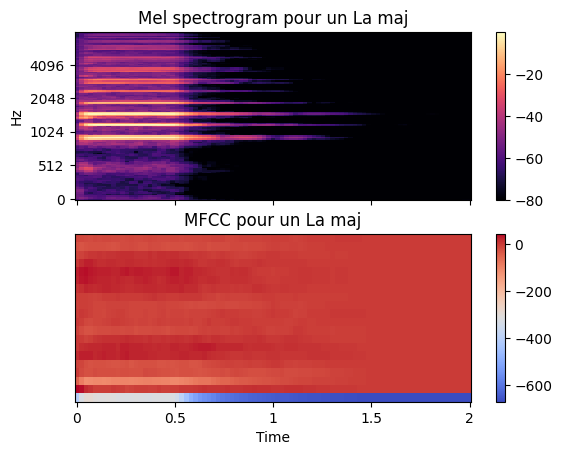

In [7]:
S = get_melspectrogram(example_file)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)

mfcc = get_mfcc(example_file)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram pour un La maj')
ax[0].label_outer()
img = librosa.display.specshow(mfcc, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC pour un La maj')

c:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\envlucie\lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=1024 is too large for input signal of length=1004
  warnings.warn(


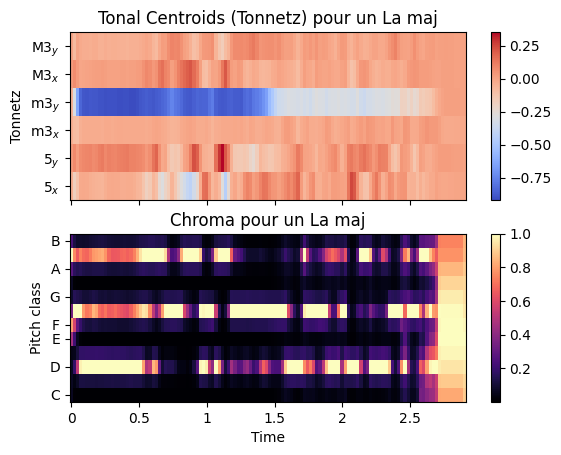

In [8]:
import matplotlib.pyplot as plt
chroma = get_chroma_vector(example_file)
tntz = get_tonnetz(example_file)

fig, ax = plt.subplots(nrows=2, sharex=True)
img1 = librosa.display.specshow(tntz,
                                y_axis='tonnetz', x_axis='time', ax=ax[0])
ax[0].set(title='Tonal Centroids (Tonnetz) pour un La maj')
ax[0].label_outer()
img2 = librosa.display.specshow(chroma,
                                y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(title='Chroma pour un La maj')
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])

In [13]:
# J'ai gardé les 2 composantes que je trouve les plus logiques ne attendnat d'en savoir plus 
# Va nous renvoyé les 128 freq moyenne, puis les 128 mion et enfin les 128 max
# Va nous renvoyé 12 * 3 = 36 valeurs, les 12 premières correspondent à la moyenne, puis au min et enfin au max

def get_feature(file_path):
  features = []

  # # Extracting mal spectrogram vector feature
  #melspectrogram = get_melspectrogram(file_path)
  #melspectrogram_mean = melspectrogram.mean(axis=1)
  #features = melspectrogram_mean

  # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)
  features = chroma_mean
  
  return features 

In [14]:
def extract_features(directory):
    features = []
    labels = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            feature = get_feature(file_path)
            label = file.split('_')[1].split('.')[0]
            features.append(feature)
            labels.append(label)

    return features, labels

In [15]:
dir = 'Chords_generation\chords_wav'
features, labels = extract_features(dir)

In [16]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [36]:
# Normalisation des caractéristiques
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [37]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(12,)))
model.add(keras.layers.Dense(35, activation='relu'))
model.add(keras.layers.Dense(103, activation='softmax'))
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/20


8/8 [==============================] - 0s 18ms/step - loss: 3.7736 - accuracy: 0.2193 - val_loss: 4.6762 - val_accuracy: 0.0408
Epoch 2/20
8/8 [==============================] - 0s 9ms/step - loss: 3.7225 - accuracy: 0.2368 - val_loss: 4.6719 - val_accuracy: 0.0408
Epoch 3/20
8/8 [==============================] - 0s 8ms/step - loss: 3.6715 - accuracy: 0.2412 - val_loss: 4.6678 - val_accuracy: 0.0408
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 3.6202 - accuracy: 0.2544 - val_loss: 4.6632 - val_accuracy: 0.0306
Epoch 5/20
8/8 [==============================] - 0s 8ms/step - loss: 3.5677 - accuracy: 0.2632 - val_loss: 4.6567 - val_accuracy: 0.0306
Epoch 6/20
8/8 [==============================] - 0s 8ms/step - loss: 3.5136 - accuracy: 0.2807 - val_loss: 4.6502 - val_accuracy: 0.0204
Epoch 7/20
8/8 [==============================] - 0s 8ms/step - loss: 3.4614 - accuracy: 0.2851 - val_loss: 4.6434 - val_accuracy: 0.0204
Epoch 8/20
8/8 [============================

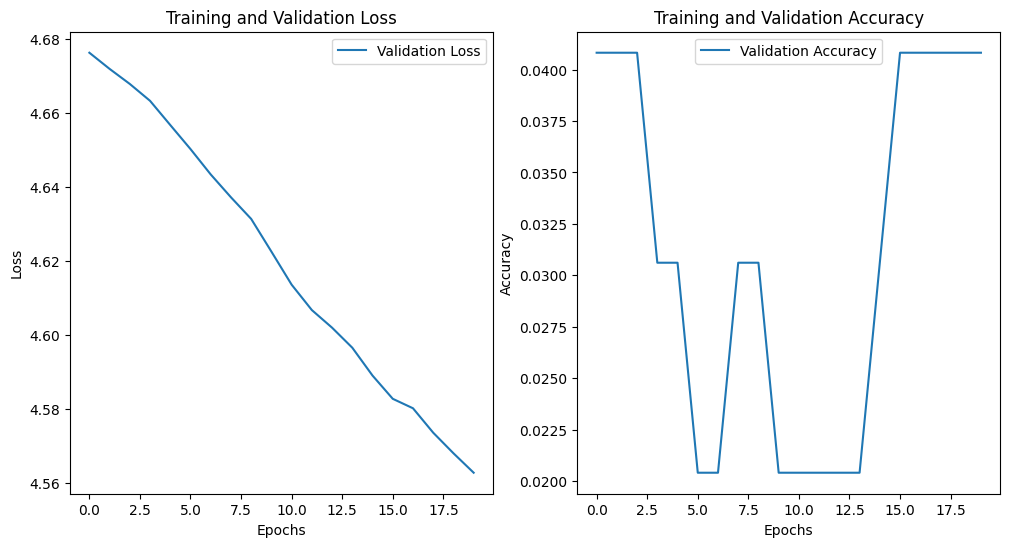

In [41]:
history =model.fit(X_train,y_train,epochs=20,validation_split=0.3)

# Récupération de l'historique de l'entraînement
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Affichage des courbes de la perte (loss)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Affichage des courbes de l'exactitude (accuracy)
plt.subplot(1, 2, 2)
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()


In [39]:
import random
import numpy as np 


# Choisissez un exemple aléatoire dans l'ensemble de test
index = random.randint(0, len(X_test) - 1)
input_test = np.expand_dims(X_test[index], axis=0)  # Convertir en forme (1, num_features) pour une prédiction unique

# Faites la prédiction
prediction = model.predict(input_test)

classe = np.argmax(prediction)

taux_confiance = max(prediction[0]) * 100
predicted_accord_name = label_encoder.inverse_transform([classe])[0]

print(f'Prédiction de classe : {classe}')
print(f'Accord prédit : {predicted_accord_name}')
print(f'Taux de confiance : {taux_confiance}%')


1/1 [==============================] - 0s 58ms/step
Prédiction de classe : 16
Accord prédit : Asus2
Taux de confiance : 2.5984784588217735%


In [40]:
y_pred = model.predict(X_test)
pred = []
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

count = 0
for i in range(len(pred)):
    if pred[i] == y_test[i]:
        count+=1

string = "Performance : " + str(count/len(y_test)*100) + "%"
print(string)


3/3 [==============================] - 0s 3ms/step
Performance : 4.878048780487805%
